# 4.1 多层感知机

## 4.1.2 激活函数

In [90]:
%matplotlib inline
import torch
import matplotlib.pyplot as plt
from IPython import display
from d2l import torch as d2l

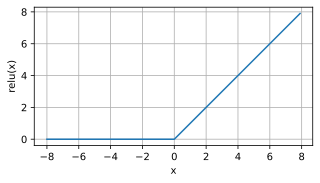

In [31]:
# relu
x = torch.arange(-8.0,8.0,0.1,requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))
plt.show()
plt.close()

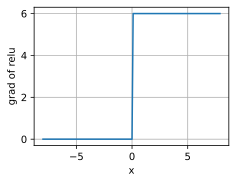

In [37]:
# relu函数的导数
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))
plt.show()
plt.close()

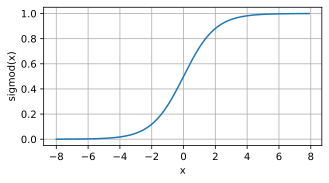

In [41]:
# sigmod函数
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmod(x)', figsize=(5,2.5))
plt.show()
plt.close()

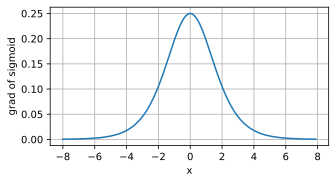

In [45]:
# sigmod函数的导数
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))
plt.show()
plt.close()

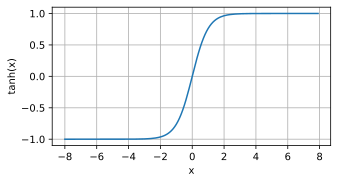

In [47]:
# tanh函数
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))
plt.show()
plt.close()

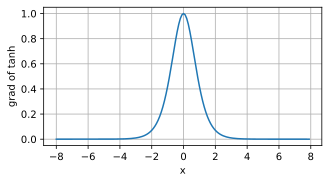

In [49]:
# tanh函数的导数
# 清除以前的梯度
x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))
plt.show()
plt.close()

# 4.2 多层感知机实现

In [51]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256

# 上一章的服饰数据集
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 4.2.1 初始化模型参数

In [56]:
num_inputs, num_outputs, num_hiddens = 784, 10, 256

W1 = nn.Parameter(torch.randn(
    num_inputs, num_hiddens, requires_grad=True) * 0.01)
b1 = nn.Parameter(torch.zeros(num_hiddens, requires_grad=True))
W2 = nn.Parameter(torch.randn(
    num_hiddens, num_outputs, requires_grad=True) * 0.01)
b2 = nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [W1, b1, W2, b2]

## 4.2.2 激活函数

In [57]:
def relu(x):
    a = torch.zeros_like(x)
    return torch.max(x, a)

## 4.2.3 模型

In [58]:
def net(x):
    x = x.reshape((-1, num_inputs))
    H = relu(x @ W1 + b1)
    return (H @ W2 + b2)

## 4.2.4 损失函数

In [60]:
loss = nn.CrossEntropyLoss(reduction='none')

CrossEntropyLoss()

## 4.2.5 训练

In [78]:
def accuracy(y_hat, y): #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # 返回最大值索引
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [84]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [85]:
# 创建两个变量，存储预测正确的数量和预测的总数量
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [86]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [87]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [88]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

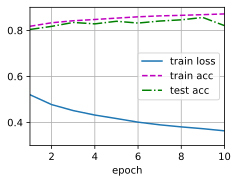

In [91]:
num_epochs, lr = 10, 0.1
updater = torch.optim.SGD(params, lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, updater)

In [93]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

d2l.predict_ch3(net, test_iter)

# 4.3 多层感知机的简介实现

## 4.3.1 模型

In [94]:
net = nn.Sequential(nn.Flatten(),
                    nn.Linear(784, 256),
                    nn.ReLU(),
                    nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

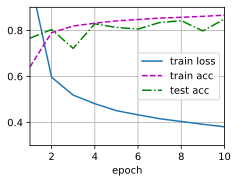

In [96]:
batch_size, lr, num_epochs = 256, 0.1, 10
loss = nn.CrossEntropyLoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=lr)

train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

# 4.4 模型选择

## 4.4.4 多项式回归

In [97]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [106]:
# 生成数据集
max_degree = 20 # 多项式的最大阶数
n_train, n_test = 100, 100 # 训练和测试数据集的大小
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5,1.2,-3.4,5.6])

features = np.random.normal(size = (n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, 
                         np.arange(max_degree).reshape(1,-1))
for i in range(max_degree):
    poly_features[:,i] /= math.gamma(i+1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [107]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-0.6024],
         [-0.2990]]),
 tensor([[ 1.0000e+00, -6.0239e-01,  1.8144e-01, -3.6433e-02,  5.4867e-03,
          -6.6103e-04,  6.6366e-05, -5.7112e-06,  4.3005e-07, -2.8784e-08,
           1.7340e-09, -9.4957e-11,  4.7668e-12, -2.2088e-13,  9.5041e-15,
          -3.8168e-16,  1.4370e-17, -5.0921e-19,  1.7041e-20, -5.4029e-22],
         [ 1.0000e+00, -2.9899e-01,  4.4696e-02, -4.4546e-03,  3.3296e-04,
          -1.9910e-05,  9.9215e-07, -4.2377e-08,  1.5838e-09, -5.2614e-11,
           1.5731e-12, -4.2758e-14,  1.0653e-15, -2.4501e-17,  5.2326e-19,
          -1.0430e-20,  1.9490e-22, -3.4278e-24,  5.6936e-26, -8.9596e-28]]),
 tensor([3.3718, 4.4636]))

In [108]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [111]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

In [112]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[ 5.0015755  1.2073857 -3.395762   5.5953526]]


In [113]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[3.2837603 4.2965283]]


In [114]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)

weight: [[ 4.987952    1.2522745  -3.3201418   5.266661   -0.24193509  1.2272266
   0.10010842  0.24028617  0.22232291 -0.0808099   0.17706123 -0.09306058
  -0.03528436 -0.10603783  0.20318513  0.04366139 -0.02793744  0.04248756
   0.0974524   0.11813709]]


# 4.5 权重衰减

## 4.5.1 高维线性回归

In [116]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [117]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

## 4.5.2 从零开始实现 

In [118]:
# 初始化模型参数
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [119]:
# 定义l2范数惩罚
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [120]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

In [121]:
# 忽略正则化直接训练
train(lambd=0)

w的L2范数是： 13.857196807861328


In [122]:
train(lambd=3)

w的L2范数是： 0.3317047953605652


## 4.5.3 简洁实现

In [123]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

In [124]:
train_concise(0)

w的L2范数： 14.09688663482666


In [125]:
train_concise(3)

w的L2范数： 0.3981977105140686


# 4.6 暂退法

In [139]:
import torch
from torch import nn
from d2l import torch as d2l

def dropout_layer(X, dropout):
    assert 0 <= dropout <= 1
    # 在本情况中，所有元素都被丢弃
    if dropout == 1:
        return torch.zeros_like(X)
    # 在本情况中，所有元素都被保留
    if dropout == 0:
        return X
    mask = (torch.rand(X.shape) > dropout).float()
    return mask * X / (1.0 - dropout)

In [138]:
x = torch.arange(16, dtype = torch.float32).reshape((2,8))
print(x)
print(dropout_layer(x, 0))
print(dropout_layer(x, 1))
print(dropout_layer(x, 0.5))

tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11., 12., 13., 14., 15.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 1., 0., 1., 1., 1., 1.],
        [0., 1., 1., 1., 0., 0., 0., 0.]])
tensor([[ 0.,  0.,  4.,  0.,  8., 10., 12., 14.],
        [ 0., 18., 20., 22.,  0.,  0.,  0.,  0.]])


In [143]:
# 定义模型参数
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

In [144]:
dropout1, dropout2 = 0.2, 0.5

class Net(nn.Module):
    def __init__(self, num_inputs, num_outputs, num_hiddens1, 
                 num_hiddens2, is_training = True):
        super(Net, self).__init__()
        self.num_inputs = num_inputs
        self.training = is_training
        self.lin1 = nn.Linear(num_inputs, num_hiddens1)
        self.lin2 = nn.Linear(num_hiddens1, num_hiddens2)
        self.lin3 = nn.Linear(num_hiddens2, num_outputs)
        self.relu = nn.ReLU()

    def forward(self, X):
        H1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        # 只有在训练模型时才使用dropout
        if self.training == True:
            # 在第一个全连接层之后添加一个dropout层
            H1 = dropout_layer(H1, dropout1)
        H2 = self.relu(self.lin2(H1))
        if self.training == True:
            # 在第二个全连接层之后添加一个dropout层
            H2 = dropout_layer(H2, dropout2)
        out = self.lin3(H2)
        return out


net = Net(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

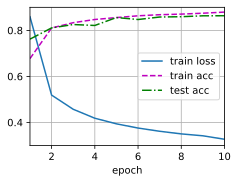

In [146]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

In [148]:
# 简洁实现
net = nn.Sequential(nn.Flatten(),
        nn.Linear(784, 256),
        nn.ReLU(),
        # 在第一个全连接层之后添加一个dropout层
        nn.Dropout(dropout1),
        nn.Linear(256, 256),
        nn.ReLU(),
        # 在第二个全连接层之后添加一个dropout层
        nn.Dropout(dropout2),
        nn.Linear(256, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

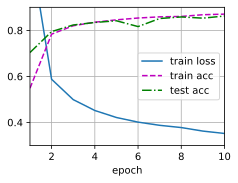

In [149]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)